In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import os
import json
import pandas as pd

def create_video_dataframe(video_dir, labels_file_path, exciting_threshold=0.7, unexciting_threshold=0.3, output_file_path='video_tags_test.csv'):
    # Load the json file containing the labels
    with open(labels_file_path, 'r') as f:
        labels = json.load(f)

    # Initialize an empty list to store the dataframe rows
    rows = []

    # Loop over the videos in the directory and extract their tags
    for video_name in os.listdir(video_dir):
        video_id = os.path.splitext(video_name)[0]  # Get video ID without extension
        label_score = labels.get(video_id, 0)  # Get label score from the json file

        if label_score > exciting_threshold:
            tag = 'exciting'
        elif label_score <= unexciting_threshold:
            tag = 'unexciting'
        else:
            tag = None

        if tag is not None:
            rows.append({'video_name': video_name, 'tag': tag})

    # Create a pandas dataframe from the rows list
    df = pd.DataFrame(rows)

    # Save the dataframe to a CSV file
    df.to_csv(output_file_path, index=False)

    return df


# df = create_video_dataframe('/Users/bunnylu/Desktop/FYP/database/video/',
# '/Users/bunnylu/Desktop/FYP/video_Exciting_clean.json', 0.5, 0.5)
df = create_video_dataframe('/content/gdrive/MyDrive/video/',
                            '/content/gdrive/MyDrive/dataset/video_Exciting_clean.json', 0.5, 0.5).drop_duplicates()


In [4]:
df = pd.read_csv('/content/video_tags_test.csv')
tag_counts = df['tag'].value_counts()
print(tag_counts)

exciting      465
unexciting    403
Name: tag, dtype: int64


In [6]:
import pandas as pd
TEST_SIZE = 0.1
VAL_SIZE = 0.2
# define the dataframe with the name and tag columns
df = pd.read_csv('video_tags_test.csv')

# count the number of exciting and unexciting videos
num_exciting = df['tag'].value_counts()['exciting']
num_unexciting = df['tag'].value_counts()['unexciting']

# calculate the number of exciting and unexciting videos to include in the training and testing sets
num_exciting_test = int(num_exciting * TEST_SIZE)
num_exciting_val = int(num_exciting * VAL_SIZE)
num_exciting_train = num_exciting - num_exciting_test - num_exciting_val
num_unexciting_test = int(num_unexciting * TEST_SIZE)
num_unexciting_val = int(num_exciting * VAL_SIZE)
num_unexciting_train = num_unexciting - num_unexciting_test - num_exciting_val

# separate the exciting and unexciting videos
exciting_videos = df[df['tag'] == 'exciting']
unexciting_videos = df[df['tag'] == 'unexciting']

# shuffle both dataframes randomly to ensure that the videos are distributed randomly
exciting_videos = exciting_videos.sample(frac=1).reset_index(drop=True)
unexciting_videos = unexciting_videos.sample(frac=1).reset_index(drop=True)

# select the specified number of exciting and unexciting videos for the training and testing sets
exciting_videos_train = exciting_videos.iloc[0:num_exciting_train]
exciting_videos_test = exciting_videos.iloc[num_exciting_train:num_exciting_train+num_exciting_test]
exciting_videos_val = exciting_videos.iloc[num_exciting_train+num_exciting_test :num_exciting]
unexciting_videos_train = unexciting_videos.iloc[0:num_unexciting_train]
unexciting_videos_test = unexciting_videos.iloc[num_unexciting_train:num_unexciting_train+num_unexciting_test]
unexciting_videos_val = unexciting_videos.iloc[num_unexciting_train+num_unexciting_test :num_unexciting]

# concatenate the exciting and unexciting videos for the training and testing sets
train_set = pd.concat([exciting_videos_train, unexciting_videos_train])
test_set = pd.concat([exciting_videos_test, unexciting_videos_test])
val_set = pd.concat([exciting_videos_val, unexciting_videos_val])

# print the resulting training and testing sets
print(num_exciting + num_unexciting)
print('Training set:', len(train_set))
print('validating set:', len(val_set))
print('Testing set:', len(test_set))
print(len(train_set) + len(test_set) + len(val_set))
train_set = train_set.sample(frac=1).reset_index(drop=True)
val_set = val_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
print(test_set)
# Save the dataframe
train_set.to_csv('train_df_test.csv', index=False)
val_set.to_csv('valid_df.csv', index=False)
test_set.to_csv('test_df_test.csv', index=False)

868
Training set: 596
validating set: 186
Testing set: 86
868
         video_name         tag
0   ctVKoj2jZLU.mp4  unexciting
1   LQqyDj7RX6Y.mp4  unexciting
2   F_M7zOew2Pc.mp4  unexciting
3   E-MRp96TgbQ.mp4  unexciting
4   WlUvQkW4B1k.mp4    exciting
..              ...         ...
81  DYYy8_GCdn4.mp4  unexciting
82  xTpv9lc_qMw.mp4    exciting
83  7LQpRQh2KSQ.mp4    exciting
84  4IaDS9MpzH0.mp4  unexciting
85  Bl6PZDkaT1I.mp4  unexciting

[86 rows x 2 columns]


In [7]:
import keras
import numpy as np
train_df = pd.read_csv('train_df_test.csv')
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['exciting', 'unexciting']


In [8]:
import cv2
import os
IMG_SIZE = 224
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
# from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os


IMG_SIZE = 224
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.1
MOMENTUM = 0.8

train_df = pd.read_csv('train_df_test.csv')
test_df = pd.read_csv('test_df_test.csv')
valid_df = pd.read_csv('valid_df.csv')

print('$$$', tf.version.VERSION)  # prints the TensorFlow version (e.g. 2.7.0)
print('$$$', tf.version.GIT_VERSION)  # prints the TensorFlow Git version (e.g. v2.7.0-rc0-18-gaf9a2fc1a1)
print('$$$', tf.version.COMPILER_VERSION)  # prints the TensorFlow compiler version (e.g. 5.0.0)


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
feature_extractor.save("/content/gdrive/MyDrive/dataset/CNN__22.15")


label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "/content/gdrive/MyDrive/video/")
valid_data, valid_labels = prepare_all_videos(valid_df, "/content/gdrive/MyDrive/video/")
test_data, test_labels = prepare_all_videos(test_df, "/content/gdrive/MyDrive/video/")
# print(test_data)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



In [11]:
print(train_labels.shape)

(596, 1)


Epoch 1/8
19/19 [==============================] - 7s 53ms/step - loss: 0.7286 - accuracy: 0.5134 - val_loss: 0.6980 - val_accuracy: 0.4731
Epoch 2/8
19/19 [==============================] - 0s 12ms/step - loss: 0.7116 - accuracy: 0.4983 - val_loss: 0.6959 - val_accuracy: 0.4570
Epoch 3/8
19/19 [==============================] - 0s 11ms/step - loss: 0.6976 - accuracy: 0.5034 - val_loss: 0.6952 - val_accuracy: 0.4892
Epoch 4/8
19/19 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.5285 - val_loss: 0.6959 - val_accuracy: 0.4892
Epoch 5/8
19/19 [==============================] - 0s 12ms/step - loss: 0.6963 - accuracy: 0.5419 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/8
19/19 [==============================] - 0s 13ms/step - loss: 0.6973 - accuracy: 0.5319 - val_loss: 0.6937 - val_accuracy: 0.4785
Epoch 7/8
19/19 [==============================] - 0s 11ms/step - loss: 0.6936 - accuracy: 0.5386 - val_loss: 0.6916 - val_accuracy: 0.4785
Epoch 8/8
19/19 [===

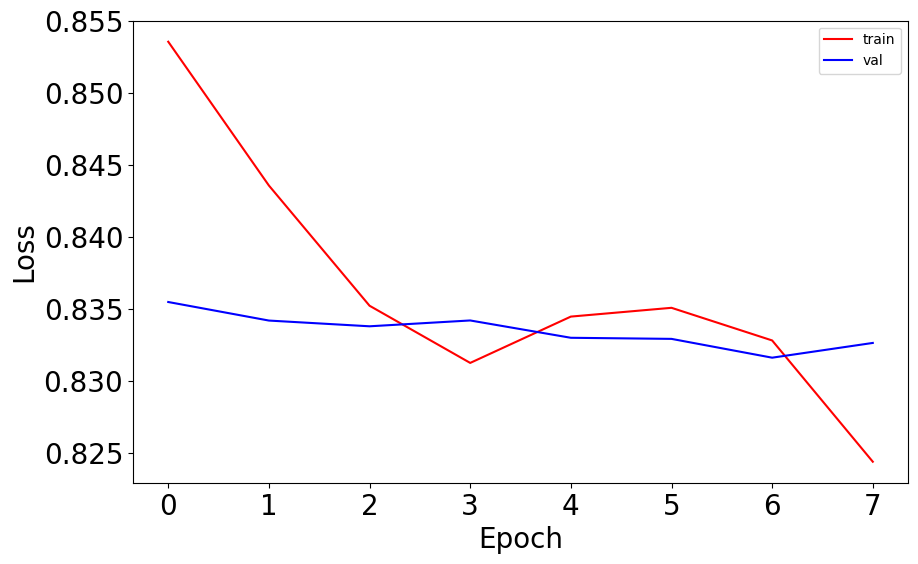

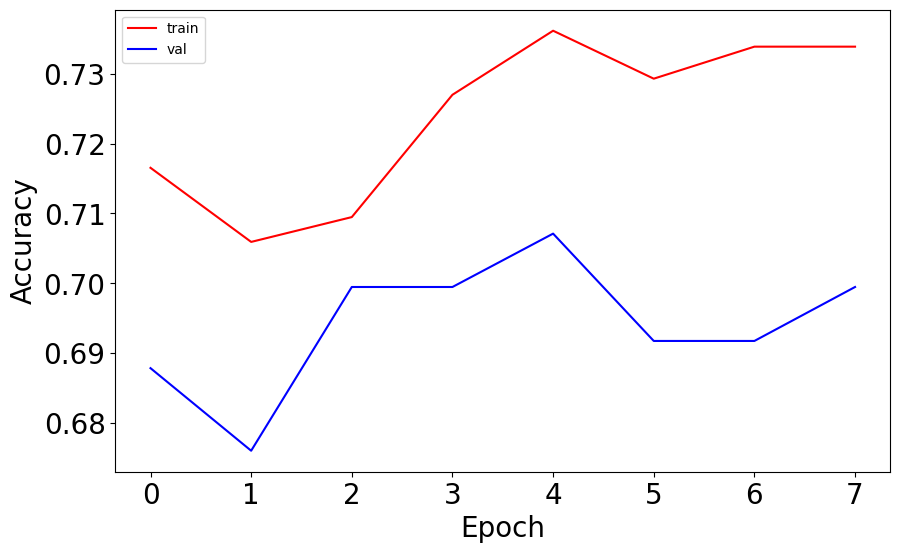

In [16]:
# from tensorflow_docs.vis import embed
from tensorflow import keras
from keras import backend as K
from imutils import paths
from keras.optimizers import SGD
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

# clear the Keras session
# K.clear_session()
# tf.keras.backend.clear_session()

# np.random.seed(42)
# tf.random.set_seed(42)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 0.0001
DECAY_RATE = 0.001
MOMENTUM = 0.8

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

def create_gru_model(gru_units=32, dense_units=8, dropout_rate=0.6, learning_rate=0.0001):
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(gru_units, return_sequences=True)(
        frame_features_input
    )
    x = keras.layers.GRU(gru_units)(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(dense_units, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    gru_model = keras.Model([frame_features_input,mask_input], output)
    gru_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate), metrics=["accuracy"]
    )
    
    return gru_model

# keras_clf = KerasClassifier(build_fn=create_gru_model)
# param_dist = {
#     'gru_units': [32, 64, 128],
#     'dense_units': [4, 8, 16],
#     'dropout_rate': [0.2, 0.4, 0.6],
#     'learning_rate': [0.0001, 0.001, 0.01],
#     'epochs': [8, 16, 24],
#     'batch_size': [16, 32, 64]
# }
# random_search = RandomizedSearchCV(
#     estimator=keras_clf,
#     param_distributions=param_dist,
#     n_iter=10,  # You can choose the number of iterations as per your requirements.
#     cv=3,
#     n_jobs=1,
#     verbose=1
# )

# gru_model_history = random_search.fit(X_train, train_labels)
# print("Best Hyperparameters: ", random_search.best_params_)
# best_model = random_search.best_estimator_.model
# _, accuracy = best_model.evaluate(test_data[0], test_labels)
# print(f"Test accuracy: {round(accuracy * 100, 5)}%")





# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
# x = keras.layers.GRU(64, return_sequences=True)(
#     frame_features_input, mask=mask_input
# )
# # x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.GRU(64)(x)
# x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(8, activation="relu")(x)
# output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)



# gru_model_09 = keras.Model([frame_features_input, mask_input], output)
# gru_model_09.summary()
# # decay_rate = LEARNING_RATE / EPOCHS

# # # Define sdg optimizer
# # sgd = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE, nesterov=False)
# gru_model_09.compile(
#     loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"]
# )
# print(lr_model)
# define the learning rate change 
# def exp_decay(epoch):
#     lrate = LEARNING_RATE * np.exp(-DECAY_RATE*epoch)
#     return lrate

# # learning schedule callback
# loss_history = History()
# lr_rate = LearningRateScheduler(exp_decay)
# es = EarlyStopping(monitor='val_loss', patience=8)
# # callbacks_list = [loss_history, lr_rate, es]
# callbacks_list = [loss_history, es]
# filepath = "/tmp/video_classifier"
# checkpoint = keras.callbacks.ModelCheckpoint(
#     filepath, save_weights_only=True, save_best_only=True, verbose=1
# )
gru_model_best_01 = create_gru_model()
# # you invoke the LearningRateScheduler during the .fit() phase
gru_model_history = gru_model_best_01.fit([train_data[0], train_data[1]], train_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    # callbacks=[callbacks_list],
                                    # callbacks=[checkpoint],
                                    verbose=1,
                                    validation_data=([valid_data[0], valid_data[1]], valid_labels)
                                    )

# serialize weights to HDF5
gru_model_best_01.save("/content/gdrive/MyDrive/dataset/gru_model_bestgrumodel_01")


# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(gru_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(gru_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(gru_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(gru_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)



# Utility for running experiments.
# def run_experiment():
#     filepath = "/tmp/video_classifier"
#     checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath, save_weights_only=True, save_best_only=True, verbose=1
    

#     seq_model = get_sequence_model()
#     history = seq_model.fit(
#         [train_data[0], train_data[1]],
#         train_labels,
#         validation_split=0.3,
#         epochs=EPOCHS,
#         callbacks=[checkpoint],
#     )

#     seq_model.load_weights(filepath)
#     _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")

#     return history, seq_model



# _, sequence_model = run_experiment()

In [17]:
print("&&&&&&", gru_model_history.history.keys())
_, accuracy = gru_model_best_01.evaluate([test_data[0], test_data[1]], test_labels)
print(f"Test accuracy: {round(accuracy * 100, 5)}%")

&&&&&& dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
3/3 [==============================] - 0s 8ms/step - loss: 0.6914 - accuracy: 0.5116
Test accuracy: 51.16279%


In [ ]:
# Test one video
from keras import models


# Load the model
model111 = models.load_model("/content/gdrive/MyDrive/dataset/gru_model")

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/content/gdrive/MyDrive/video/", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = model111.predict([frame_features, frame_mask])[0]
    # probabilities = svc.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


for i in range(88):
  # evaluate loaded model on test data
  test_video = np.random.choice(test_df["video_name"].values.tolist())
  print(f"Test video path: {test_video}")
  test_frames = sequence_prediction(test_video)
  # test_frames = getSVC_prediction(test_video)
  # class_names = label_processor.get_vocabulary()


# Map the numeric predictions to their corresponding class names
# y_pred_class_names = np.array(class_names)[y_pred_test]
# print(y_pred_class_names)
# print(label_processor.get_vocabulary())

In [ ]:
import numpy as np
from keras.layers import Input, LSTM, Dense, Dropout, Multiply
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import History, LearningRateScheduler, EarlyStopping

    def lstm(self):
        """Build a simple LSTM network. We pass the extracted features from
        our CNN to this model predomenently."""
        # Model.
        model = Sequential()
        model.add(LSTM(2048, return_sequences=False,
                       input_shape=self.input_shape,
                       dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model
def get_lstm_model():
    class_vocab = label_processor.get_vocabulary()
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    features_input = Input(shape=frame_features.shape[1:], name='features_input')
    masks_input = Input(shape=frame_mask.shape[1:], name='masks_input')

    # Reshape the masks_input to match the features_input shape.
    masks_input_reshaped = tf.keras.layers.Reshape((MAX_SEQ_LENGTH, 1))(masks_input)

    # Multiply features_input with masks_input_reshaped.
    masked_features = Multiply()([features_input, masks_input_reshaped])

    # Model.
    lstm_layer = LSTM(2048, return_sequences=False, dropout=0.5)(masked_features)
    dense_layer = Dense(512, activation='relu')(lstm_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(len(class_vocab), activation='softmax')(dropout_layer)

    # Create the model with two inputs.
    model = Model([features_input, masks_input], output_layer)

    return model

lstm_model = get_lstm_model()
lstm_model.summary()

# Define sdg optimizer
sgd = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE, nesterov=False)
lstm_model.compile(
    loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]
)

# define the learning rate change 
def exp_decay(epoch):
    lrate = LEARNING_RATE * np.exp(-DECAY_RATE*epoch)
    return lrate

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
es = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [loss_history, lr_rate, es]

# you invoke the LearningRateScheduler during the .fit() phase
lstm_model_history = lstm_model.fit([train_data[0], train_data[1]], train_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    callbacks=[callbacks_list],
                                    verbose=1,
                                    validation_data=([valid_data[0], valid_data[1]], valid_labels)
                                    )

print("&&&&&&", lstm_model_history.history.keys())
_, accuracy = lstm_model.evaluate([test_data[0], test_data[1]], test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 masks_input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 features_input (InputLayer)    [(None, 20, 2048)]   0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 20, 1)        0           ['masks_input[0][0]']            
                                                                                                  
 multiply_1 (Multiply)          (None, 20, 2048)     0           ['features_input[0][0]',         
                                                                  'reshape_1[0][0]']        

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 11s 5s/step - loss: 0.7193 - accuracy: 0.5068 - val_loss: 0.6942 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/60
3/3 [==============================] - 0s 86ms/step - loss: 0.7794 - accuracy: 0.4110 - val_loss: 0.6939 - val_accuracy: 0.6000 - lr: 9.9900e-04
Epoch 3/60
3/3 [==============================] - 0s 70ms/step - loss: 0.6897 - accuracy: 0.5479 - val_loss: 0.6967 - val_accuracy: 0.5500 - lr: 9.9800e-04
Epoch 4/60
3/3 [==============================] - 0s 70ms/step - loss: 0.6551 - accuracy: 0.6712 - val_loss: 0.7017 - val_accuracy: 0.5500 - lr: 9.9700e-04
Epoch 5/60
3/3 [==============================] - 0s 71ms/step - loss: 0.6471 - accuracy: 0.6164 - val_loss: 0.7107 - val_accuracy: 0.5000 - lr: 9.9601e-04
Epoch 6/60
3/3 [==============================] - 0s 69ms/step - loss: 0.6172 - accuracy: 0.7260 - val_loss: 0.7031 - val_accuracy: 0.5000 - lr: 9.9501e-04
Epoch 7/60
3/3 [==============================] - 0s 73ms/step - loss: 0.6238 - 

In [ ]:
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Multiply, Reshape
from keras.models import Model
IMG_SIZE = 224
MAX_SEQ_LENGTH = 20
def get_3d_cnn_model():
    num_classes = len(label_processor.get_vocabulary())
    NUM_CHANNELS = 3
    IMG_HEIGHT = IMG_SIZE
    IMG_WIDTH = IMG_SIZE

    input_shape = (MAX_SEQ_LENGTH, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    video_input = Input(shape=input_shape, name='video_input')

    # 3D CNN model.
    x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(video_input)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the model with video input.
    model = Model(inputs=video_input, outputs=output_layer)

    return model

cnn_3d_model = get_3d_cnn_model()
cnn_3d_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 video_input (InputLayer)    [(None, 20, 224, 224, 3)  0         
                             ]                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 20, 224, 224, 16)  1312      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 20, 112, 112, 16)  0        
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 20, 112, 112, 32)  13856     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 56, 56, 32)   0         
 3D)                                                             
                                                           

In [ ]:
import cv2

def prepare_3DConv_videos(df, video_dir):
    video_data = []
    video_labels = []

    for index, row in df.iterrows():
        video_path = os.path.join(video_dir, row['video_name'])
        video_frames = load_video(video_path, MAX_SEQ_LENGTH)
        video_data.append(video_frames)

        # One-hot encode the label
        label = label_processor(row['tag'])
        video_labels.append(label.numpy())

    video_data = np.array(video_data)
    video_labels = np.array(video_labels)

    return video_data, video_labels

train_df = pd.read_csv('train_df_test.csv')
valid_df = pd.read_csv('valid_df.csv')
test_df = pd.read_csv('test_df_test.csv')

video_dir = "/content/gdrive/MyDrive/dataset/50videos/"

train_data, train_labels = prepare_3DConv_videos(train_df, video_dir)
valid_data, valid_labels = prepare_3DConv_videos(valid_df, video_dir)
test_data, test_labels = prepare_3DConv_videos(test_df, video_dir)

# print(train_data.shape)
# print("TEST****", test_data)
# print("TEST****", test_labels)

In [ ]:
print(train_data.shape)
print(train_labels.shape)

(73, 20, 224, 224, 3)
(73,)


In [ ]:
import traceback
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


cnn_3d_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
BATCH_SIZE = 8
EPOCHS = 20

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
es = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [loss_history, lr_rate, es]

try:
    history = cnn_3d_model.fit(train_data, train_labels,
                               validation_data=(valid_data, valid_labels),
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS
                              #  callbacks=[callbacks_list]
                               )
except Exception as e:
    print("Error occurred during training:")
    print(e)
    traceback.print_exc()


# Evaluate the model
_, accuracy = cnn_3d_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 5)}%")


# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# Compile the model
LEARNING_RATE = 0.1
MOMENTUM = 0.8
DECAY_RATE = 1e-6
BATCH_SIZE = 32
EPOCHS = 10

sgd = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE, nesterov=False)
cnn_3d_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

# Define the learning rate schedule
def exp_decay(epoch):
    lrate = LEARNING_RATE * np.exp(-DECAY_RATE * epoch)
    return lrate

# Callbacks
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
es = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [loss_history, lr_rate, es]

# Fit the model
cnn_3d_model_history = cnn_3d_model.fit(train_data,train_labels,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=callbacks_list,
                                        verbose=1,
                                        validation_data=(valid_data, valid_labels))

# Evaluate the model
_, accuracy = cnn_3d_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
2/3 [===================>..........] - ETA: 0s - loss: nan - accuracy: 0.5156

ValueError: ignored